# Note:
The code doesn't function as it should, but I gave it a (elaborate) shot.

A few weird things:
- the outputs for $w_R$ and $w_L$ co-develop into the binocular behaviour; there is no dominance, instead, the weights increase together. Consequently, $w_-$ does not portray steady increase, but just a decrease in activity. Moreover, $w_+$ does not develop into the expected steady equilibrium state.
- there seems to be a gradual increase in intensity from neuron 0 to neuron 512. I can't figure out what the computational reason for this is. K is symmetric and W is completely random, so I expected the reason to be Q. However, exactly reversing the inputs and their weight-scaling, the exact same pattern emerges, not going in the other direction. So I don't know to which element to attribute this weird phenomenon to.




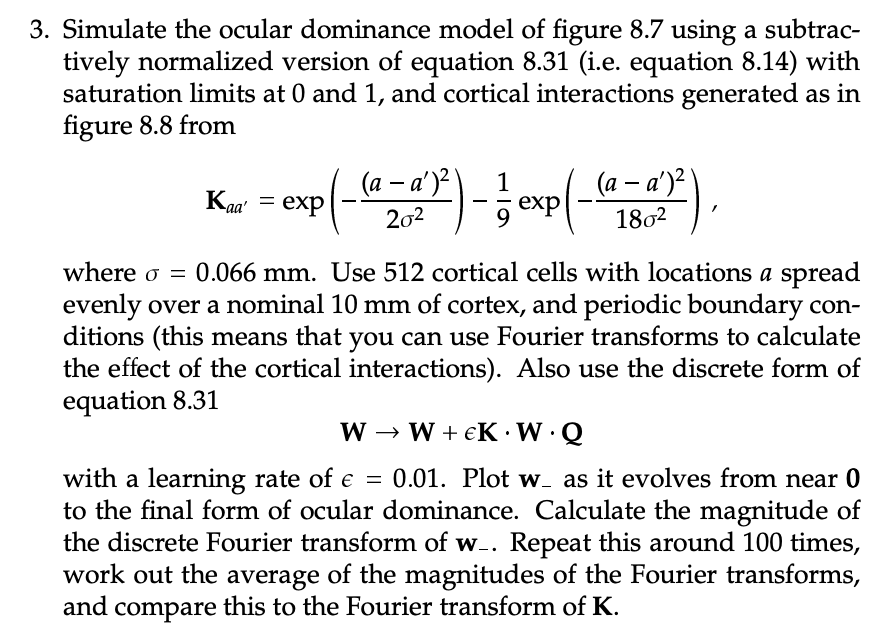

Two inputs, $u_L$ and $u_R$ that have correlation matrix $Q$.


The inputs are connected to multiple output units through weight vectors $\overrightarrow{w_L}$ and $\overrightarrow{w_R}$ respectively.


Moreover, the output units are connected to each other recurrently through weights $\overrightarrow{M}$ such that

$$
\overrightarrow{v} = \overrightarrow{w_R} u_R + \overrightarrow{w_L}u_L + \overrightarrow{M}· \overrightarrow{v}
$$

Finally, we can write

$$
\overrightarrow{w_-} = \overrightarrow{w_R}-\overrightarrow{w_L}
$$

To avoid edge effects we impose periodicity by imposing that the activities of neurons at $a=0$ and $a=N_v$ to be equal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from scipy.fftpack import fft
from scipy.signal import correlate

In [2]:
def K_calc(a1,a2,sigma):
  return np.exp(-((a1-a2)**2)/(2*sigma**2))- 1/9 * np.exp(-((a1-a2)**2)/(18*sigma**2))

# parameters
N = 512
sigma = 0.066 # mm
a_max = 10 # mm
eps = 0.01

# initialize unit positions and a matrix for their interactions
a_pos = np.linspace(0,a_max,N)
K = np.zeros([N,N])

# set up the cortical interaction matrix
for i in range(N):
  for j in range(N):
    K[i,j]=K_calc(a_pos[i],a_pos[j],sigma)

# # set periodic bounds
K[-1,0] = K.max()
K[0,-1] = K.max()

def simulation(inputs, weight_scaling, plotting):

  wL_scale,wR_scale = weight_scaling
  # set up the feed forward weights
  # if weights [0,1]
  w_L = np.random.rand(N)*wL_scale
  w_R = np.random.rand(N)*wR_scale
  W = np.array([w_L,w_R])
  W = W.reshape([-1,2])

  # # if weights [-1,1]
  # w_R = (np.random.rand(N)-0.5)*2 * 0.1
  # w_L = (np.random.rand(N)-0.5)*2 * 0.7
  # W = np.array([w_L,w_R]) # feed-forward connections
  # W = W.reshape([-1,2])

  # set up the autocorrelation matrix of the input - this determines the evolution of the weights
  input = inputs

  Q = np.zeros((2,2))
  for i in range(2):
    for j in range(2):
      Q[i,j] = correlate(input[i],input[j],mode='full')

  # next, dynamics update rule given by W -> W + eps K * W * Q

  Wt = []

  runs = 100
  for i in range(runs):
    W = W + eps*K @ W @ Q
    # W = np.clip(W,0,1)
    Wt.append(W)

  Wt = np.reshape(Wt, [len(input),N,runs])

  if plotting:
    plt.imshow((Wt[1]-Wt[0]).T)
    plt.colorbar()
    plt.xlabel('cortical neurons')
    plt.ylabel('time')
    plt.title('$w_- = w_R - w_L$')
    plt.show()

    plt.imshow((Wt[0,:40]).T)
    plt.colorbar()
    plt.xlabel('cortical neurons')
    plt.ylabel('time')
    plt.title('$w_L$')
    plt.show()

    plt.imshow((Wt[1,:40]).T)
    plt.colorbar()
    plt.xlabel('cortical neurons')
    plt.ylabel('time')
    plt.title('$w_R$')
    plt.show()

    check = W[:,1]-W[:,0]/Wt.max()
    plt.plot(np.abs(np.fft.fft(check)))
    plt.title('frequency spectrum $w_-$')
    plt.show()

    plt.plot(np.mean(np.abs(np.fft.fft(K)),axis=1))
    plt.title('frequency spectrum K')
    plt.show()

  return Wt

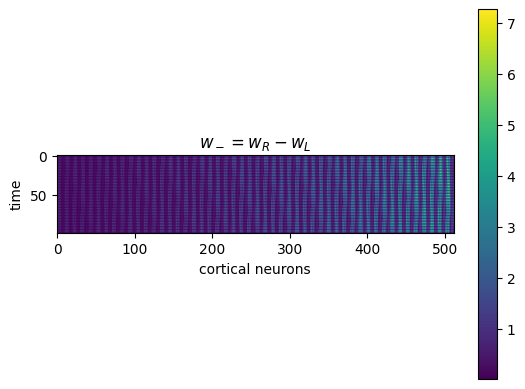

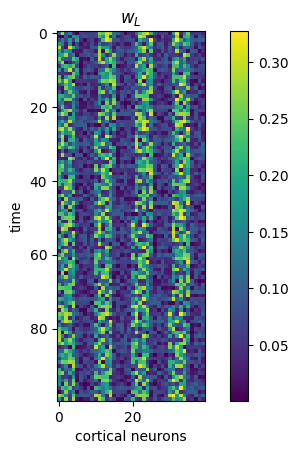

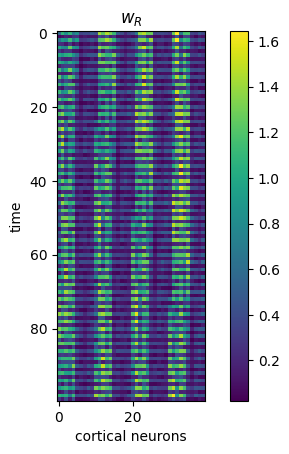

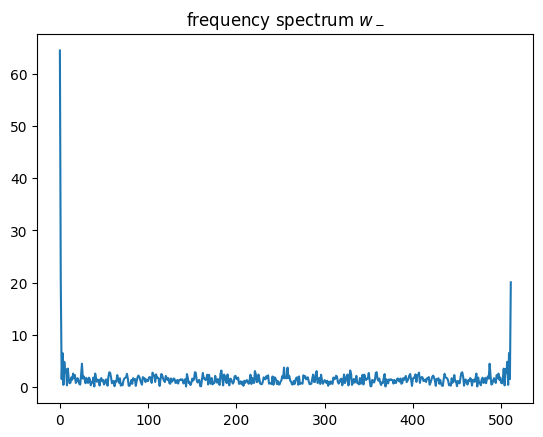

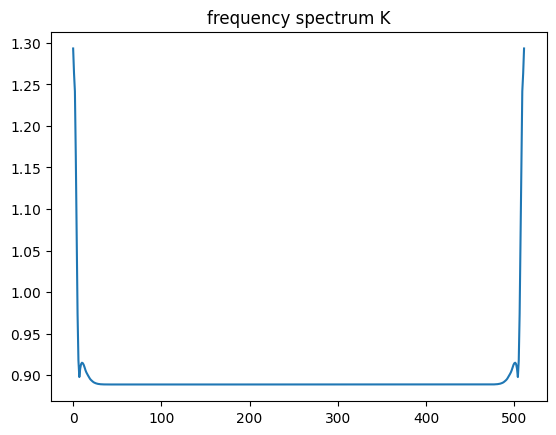

In [3]:
# WIDELY DIFFERING INPUTS AND WEIGHT SCALING
Wt = simulation(inputs = [0.8,0.1], weight_scaling = [0.3,0.1], plotting = True)

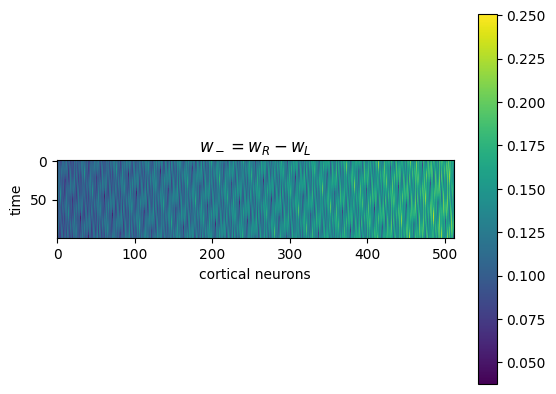

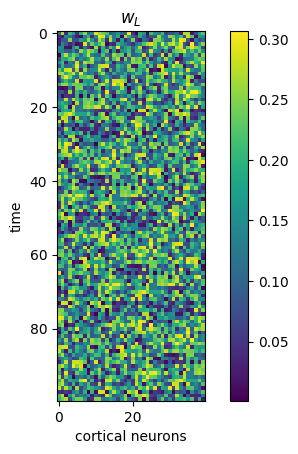

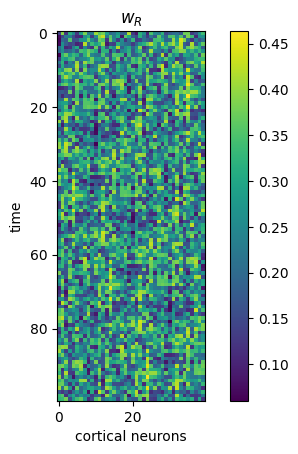

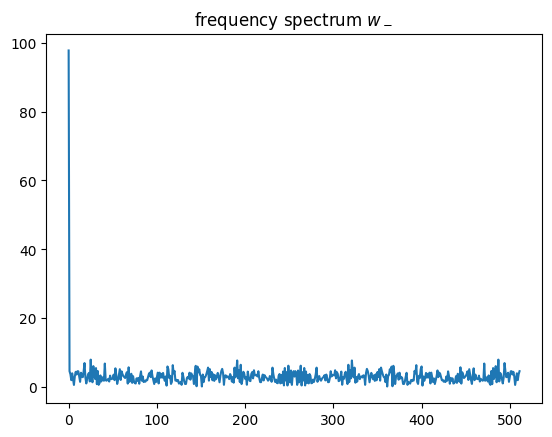

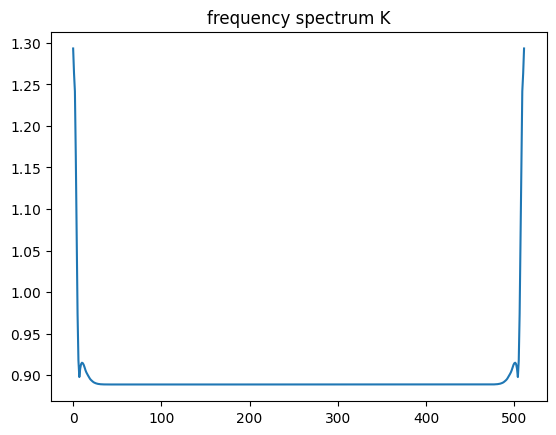

In [4]:
# SAME INPUTS AND SAME WEIGHT SCALING
Wt = simulation(inputs = [0.3,0.3], weight_scaling = [0.3,0.3], plotting = True)

Acting weird, don't really get it...

Let's try numerical integration of equation 8.32 instead :)

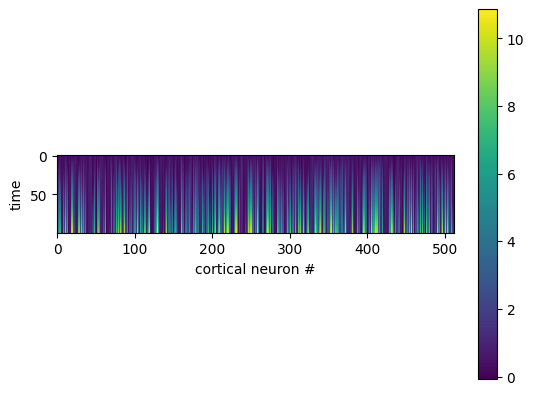

In [5]:
from scipy.integrate import solve_ivp

input = [0.1,0.7]
wL_scale, wR_scale = [0.1,0.9]

tau_w = 1


Q = np.zeros((2,2))
for i in range(2):
  for j in range(2):
    Q[i,j] = correlate(input[i],input[j],mode='full')

w_L = np.random.rand(N)*wL_scale
w_R = np.random.rand(N)*wR_scale
w_min_start = w_R-w_L


K = np.random.randn(N,N) # RANDOM INTERACTION MATRIX


def w_minus(t,w):
  return np.clip((Q[0,0]-Q[0,1])/tau_w * K@w,0,1)

t_val = np.linspace(0,10,100)
sol = solve_ivp(w_minus, [t_val[0],t_val[-1]], w_min_start, t_eval = t_val)

use = sol.y
plt.imshow((use).T)
plt.colorbar()
plt.ylabel('time')
plt.xlabel('cortical neuron #')
plt.show()

In [6]:
def K_calc(a1,a2,sigma):
  return np.exp(-((a1-a2)**2)/(2*sigma**2))- 1/9 * np.exp(-((a1-a2)**2)/(18*sigma**2))

# parameters
N = 512
sigma = 0.066 # mm
a_max = 10 # mm
eps = 0.1

# initialize unit positions and a matrix for their interactions
a_pos = np.linspace(0,a_max,N)
K_cortical = np.zeros([N,N])

# set up the cortical interaction matrix
for i in range(N):
  for j in range(N):
    K_cortical[i,j]=K_calc(a_pos[i],a_pos[j],sigma)

# # set periodic bounds
K_cortical[-1,0] = K.max()
K_cortical[0,-1] = K.max()


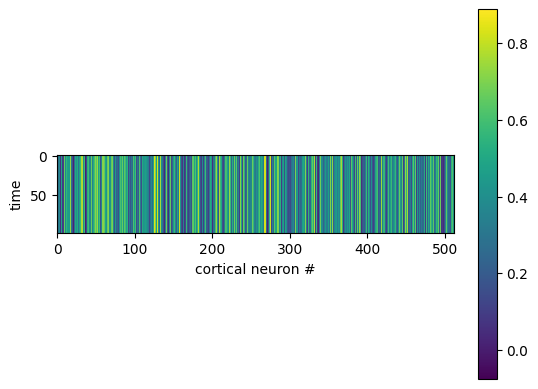

In [7]:
from scipy.integrate import solve_ivp

input = [0.1,0.7]
wL_scale, wR_scale = [0.1,0.9]

tau_w = 1

Q = np.zeros((2,2))
for i in range(2):
  for j in range(2):
    Q[i,j] = correlate(input[i],input[j],mode='full')


w_L = np.random.rand(N)*wL_scale
w_R = np.random.rand(N)*wR_scale
w_min_start = w_R-w_L

def w_minus(t,w):
  return np.clip((Q[0,0]-Q[0,1])/tau_w * K_cortical @w,0,1) # APPROPRIATE INTERACTION MATRIX K1

t_val = np.linspace(0,10,100)
sol = solve_ivp(w_minus, [t_val[0],t_val[-1]], w_min_start, t_eval = t_val)

use = sol.y
plt.imshow((use).T)
plt.colorbar()
plt.ylabel('time')
plt.xlabel('cortical neuron #')
plt.show()

For some reason, a randomized interaction matrix seems to develop from completely random to ocular dominant. The actual interaction matrix just stays stagnant...
Dysfunctional.